# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

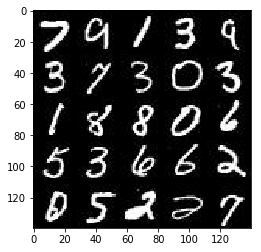

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

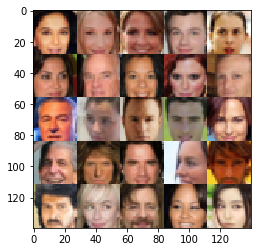

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
drop_rate = 0.2
alpha = 0.15
smooth = 0.2

In [7]:
def LeakyReLU(inputs):
    return tf.maximum(inputs * alpha, inputs)

def xavier_init(size, dtype, partition_info):
    
    in_dim = size[-1]
    xavier_stddev = 1. / tf.sqrt(in_dim * 1.)
    return tf.random_normal(shape=size, stddev=xavier_stddev, dtype=dtype)

def discriminator(images, reuse=False, is_training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 3, padding="same", activation=None, kernel_initializer=xavier_init)
        x1 = tf.layers.average_pooling2d(x1, 3, strides=2)
        
        relu1 = LeakyReLU(x1)
        relu1 = tf.layers.dropout(relu1, drop_rate)
        
        x2 = tf.layers.conv2d(relu1, 128, 3, padding="same", activation=None, kernel_initializer=xavier_init)
        x2 = tf.layers.average_pooling2d(x2, 3, strides=2)

        bn2 = tf.layers.batch_normalization(x2, training=is_training)
        relu2 = LeakyReLU(bn2)
        relu2 = tf.layers.dropout(relu2, drop_rate)
        
        x3 = tf.layers.conv2d(relu2, 512, 3, padding="same", activation=None, kernel_initializer=xavier_init)
        x3 = tf.layers.average_pooling2d(x3, 3, strides=2)
        
        bn3 = tf.layers.batch_normalization(x3, training=is_training)
        relu3 = LeakyReLU(bn3)
        relu3 = tf.layers.dropout(relu3, drop_rate)
        
        flat = tf.contrib.layers.flatten(relu3)
        output = tf.layers.dense(flat, 1)
    
    return tf.nn.sigmoid(output), output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = LeakyReLU(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 3, strides=2, padding="same", kernel_initializer=xavier_init)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = LeakyReLU(x2)
        x2 = tf.layers.dropout(x2, drop_rate, training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding="same", kernel_initializer=xavier_init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = LeakyReLU(x3)
        x3 = tf.layers.dropout(x3, drop_rate, training=is_train)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=1, padding="same", kernel_initializer=xavier_init)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = LeakyReLU(x4)
        x4 = tf.layers.dropout(x4, drop_rate, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding="same", kernel_initializer=xavier_init)
        
        g = tf.tanh(logits)

    return g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)


Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, batch_size=32):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    D_real_out, D_real_digits = discriminator(input_real, reuse=False)
    G_model = generator(input_z, out_channel_dim, True)
    D_fake_out, D_fake_digits = discriminator(G_model, reuse=True)
    """
    lam = 10
    eps = tf.random_uniform([batch_size, *input_real.get_shape().as_list()[1:]], minval=0., maxval=1.)
    X_inter = eps * input_real + (1 - eps) * G_model
    grad = tf.gradients(discriminator(X_inter, reuse=True)[1], [X_inter])[0]
    
    grad_norm = tf.sqrt(tf.reduce_sum((grad) ** 2, axis=1))
    grad_pen = lam * tf.reduce_mean(grad_norm - 1.) ** 2
    
    tf.identity(grad_pen, name="grad_pen")
    tf.identity(grad_norm, name="grad_norm")
    
    D_loss = tf.reduce_mean(D_fake_digits) - tf.reduce_mean(D_real_digits) + grad_pen
    G_loss = -tf.reduce_mean(D_fake_digits)
    """
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_digits, 
                                                labels=tf.ones_like(D_real_digits) * (1.0 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_digits,
                                               labels=tf.ones_like(D_fake_digits) * (smooth))
    )
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_digits,
                                               labels=tf.ones_like(D_fake_digits))
    )
    D_loss = d_loss_real + d_loss_fake
    
    
    #G_loss = -tf.reduce_mean(D_fake_digits)
    #D_loss = tf.reduce_mean(D_fake_digits) - tf.reduce_mean(D_real_digits)
    
    return D_loss, G_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    d_var = [var for var in variables if var.name.startswith('discriminator')]
    g_var = [var for var in variables if var.name.startswith("generator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss,
                                                                                            var_list=d_var)
        G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss,
                                                                                            var_list=g_var)

    return D_solver, G_solver


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
losses = []
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          save_folder=None, base_i=0, load_path=None):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], batch_size)
    d_solver, g_solver = model_opt(d_loss, g_loss, lr, beta1)

    tf.contrib.layers.summarize_tensors(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
    tf.summary.scalar("d_loss", d_loss)
    tf.summary.scalar("g_loss", g_loss)
    
    merge_all = tf.summary.merge_all()
    if save_folder and not os.path.exists(save_folder):
        os.mkdir(save_folder)
        
    tf.contrib.layers.summaries.summarize_variables()
    global alpha, drop_rate, smooth

    with tf.Session() as sess:
        print("begin train")
        saver = tf.train.Saver()
        if load_path:
            saver.restore(sess, load_path)
        else:
            sess.run(tf.global_variables_initializer())
        
        graph = tf.get_default_graph()
        writer = tf.summary.FileWriter("log/{}/lr={} bet={} smooth={} al={} dr={} zdim={}/8".format(save_path, learning_rate,
                                                                                      beta1,
                                                                                      smooth,
                                                                                      alpha,
                                                                                      drop_rate, 
                                                                                      z_dim), graph)
        begin_time = time.time()
        count = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                
                batch_z = np.random.normal(0., 1., size=(batch_size, z_dim))
                for d_i in range(1):
                    # train discriminator more
                    _ = sess.run(d_solver, feed_dict={input_real: batch_images, 
                                                  input_z: batch_z, 
                                                  lr: learning_rate})
                for d_i in range(6):
                    _ = sess.run(g_solver, feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z,
                        lr: learning_rate
                    })
                train_loss_d, train_loss_g, summary = sess.run([d_loss, g_loss, merge_all], feed_dict={
                    input_z: batch_z, input_real:batch_images
                })
                count += 1
                writer.add_summary(summary, count)
                losses.append((train_loss_d, train_loss_g))
                if count % 50 == 0:
                    interval = (time.time() - begin_time) / 50.
                    begin_time = time.time()
                    print("Epoch {}".format(count),
                          "Each train cost time: {}".format(interval),
                         "Discriminator Loss: {:.4f} ".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    showLoss()
                
                if save_folder and count % 300 == 0:

                    saver.save(sess, "{}/lr={} bet={} smooth={} al={} dr={}.ckpt".format(save_folder,
                                                                  learning_rate,
                                                                  beta1,
                                                                  smooth,
                                                                  alpha,
                                                                  drop_rate))
        showLoss()
def showLoss():
    fig, ax = pyplot.subplots()
    loss_ar = np.array(losses)
    pyplot.plot(loss_ar.T[0], label="discriminator", alpha=0.5)
    pyplot.plot(loss_ar.T[1], label="generator", alpha=0.5)
    pyplot.title("Training loss")
    pyplot.legend()
    pyplot.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

begin train
Epoch 50 Each train cost time: 3.1342885589599607 Discriminator Loss: 1.4260  Generator Loss: 0.5878


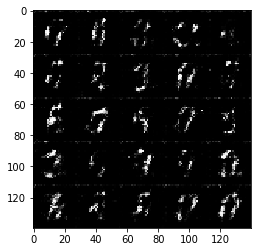

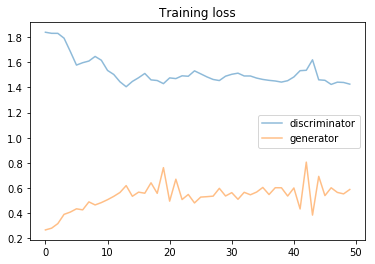

Epoch 100 Each train cost time: 3.1146410083770752 Discriminator Loss: 1.5029  Generator Loss: 0.4467


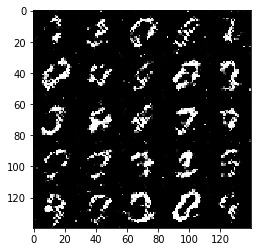

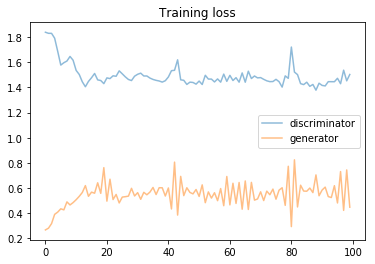

Epoch 150 Each train cost time: 3.126657347679138 Discriminator Loss: 1.4212  Generator Loss: 0.5442


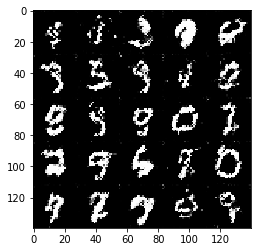

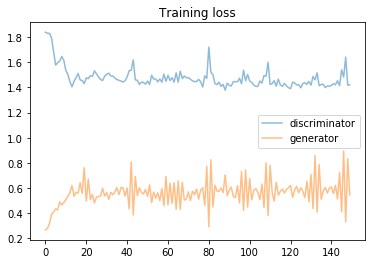

Epoch 200 Each train cost time: 3.195663847923279 Discriminator Loss: 1.4270  Generator Loss: 0.5986


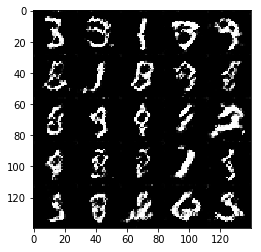

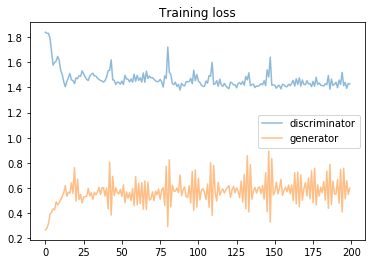

Epoch 250 Each train cost time: 3.137639117240906 Discriminator Loss: 1.4332  Generator Loss: 0.6193


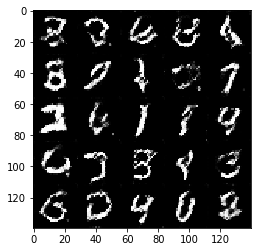

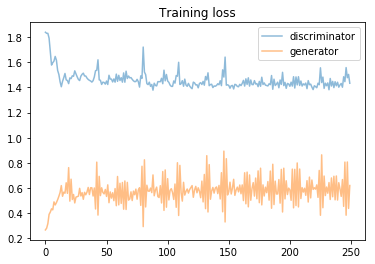

Epoch 300 Each train cost time: 3.119871873855591 Discriminator Loss: 1.4569  Generator Loss: 0.5373


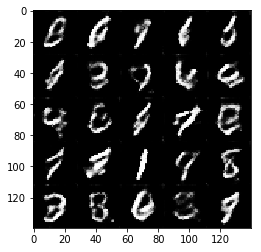

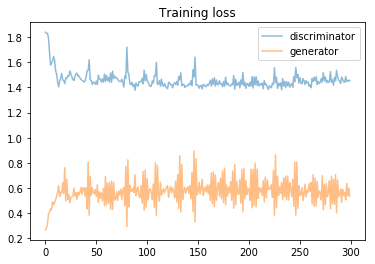

Epoch 350 Each train cost time: 3.1592552280426025 Discriminator Loss: 1.4759  Generator Loss: 0.5098


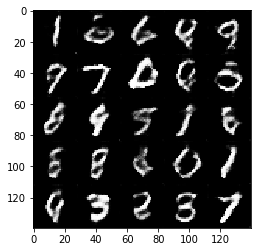

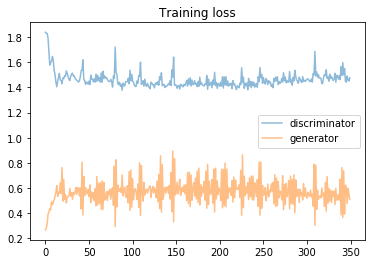

Epoch 400 Each train cost time: 3.1471190595626832 Discriminator Loss: 1.4809  Generator Loss: 0.5023


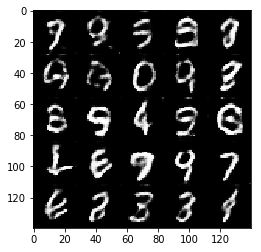

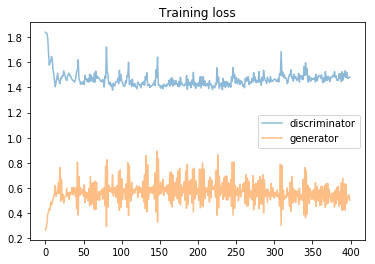

Epoch 450 Each train cost time: 3.1062571144104005 Discriminator Loss: 1.5025  Generator Loss: 0.5015


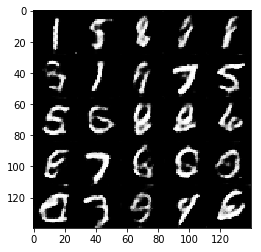

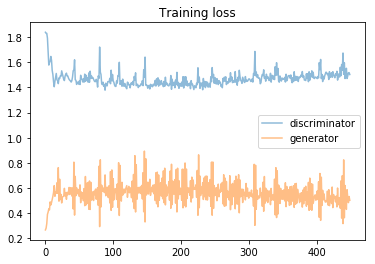

Epoch 500 Each train cost time: 3.1053015995025635 Discriminator Loss: 1.5238  Generator Loss: 0.4989


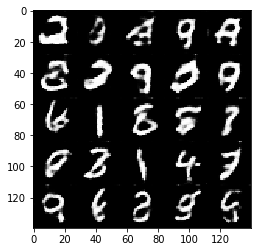

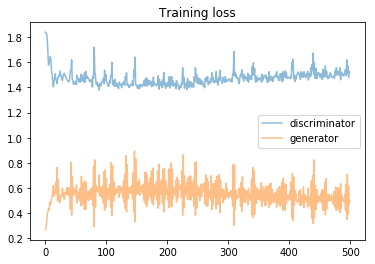

Epoch 550 Each train cost time: 3.139259629249573 Discriminator Loss: 1.4769  Generator Loss: 0.6420


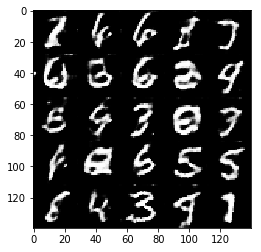

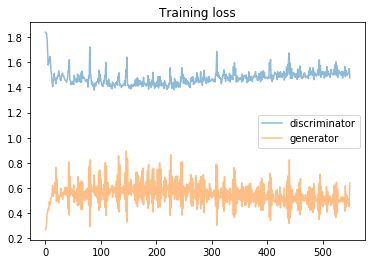

Epoch 600 Each train cost time: 3.117573466300964 Discriminator Loss: 1.4979  Generator Loss: 0.6017


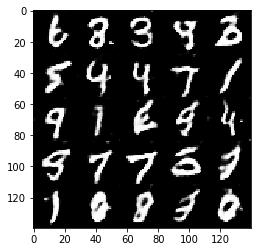

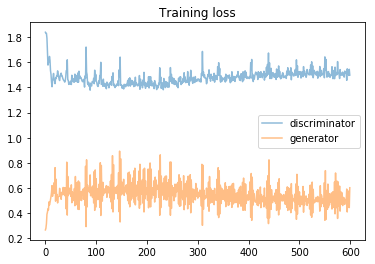

Epoch 650 Each train cost time: 3.155559525489807 Discriminator Loss: 1.4983  Generator Loss: 0.5401


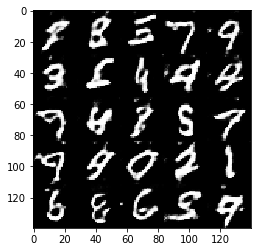

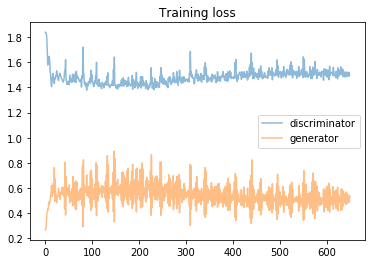

Epoch 700 Each train cost time: 3.12738618850708 Discriminator Loss: 1.5182  Generator Loss: 0.4560


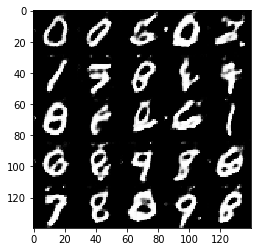

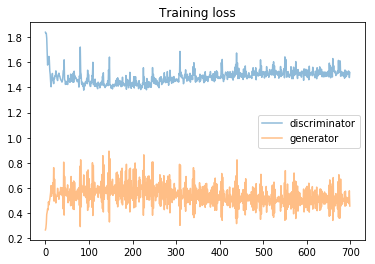

Epoch 750 Each train cost time: 3.1276445055007933 Discriminator Loss: 1.4851  Generator Loss: 0.6904


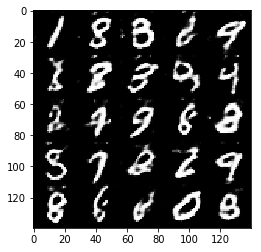

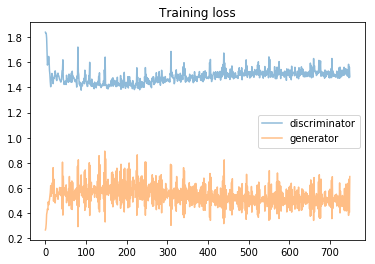

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 2e-4
beta1 = 0.45

losses = []
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
save_path = "mnist_save"

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, save_path)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

begin train
Epoch 50 Each train cost time: 3.638186149597168 Discriminator Loss: 1.6951  Generator Loss: 0.5052


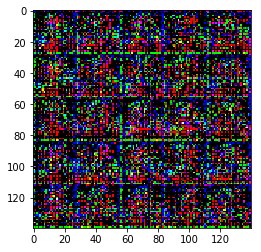

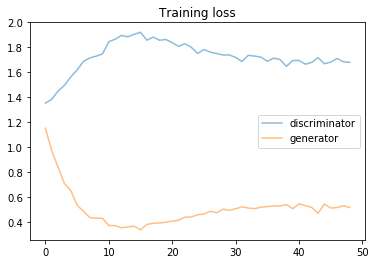

Epoch 100 Each train cost time: 3.5379912090301513 Discriminator Loss: 1.6136  Generator Loss: 0.5719


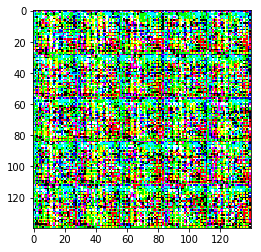

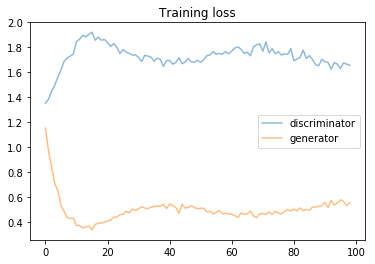

Epoch 150 Each train cost time: 3.5613926887512206 Discriminator Loss: 1.6182  Generator Loss: 0.5325


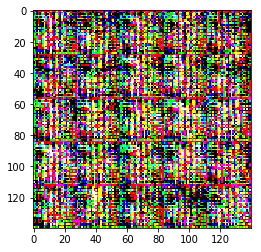

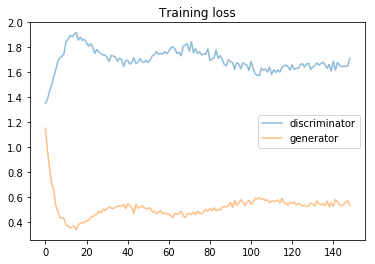

Epoch 200 Each train cost time: 3.6000137758255004 Discriminator Loss: 1.5661  Generator Loss: 0.5967


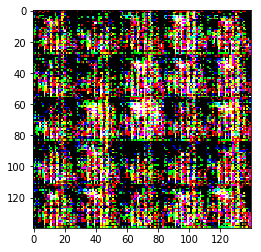

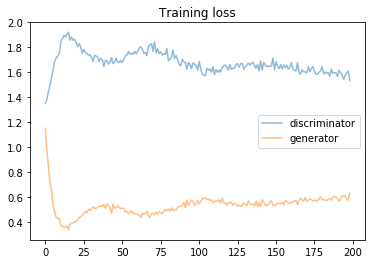

Epoch 250 Each train cost time: 3.706131029129028 Discriminator Loss: 1.5759  Generator Loss: 0.5706


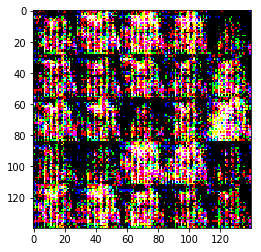

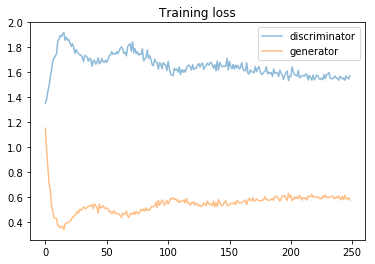

Epoch 300 Each train cost time: 3.683901143074036 Discriminator Loss: 1.5318  Generator Loss: 0.5969


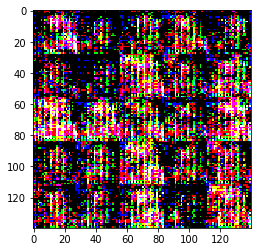

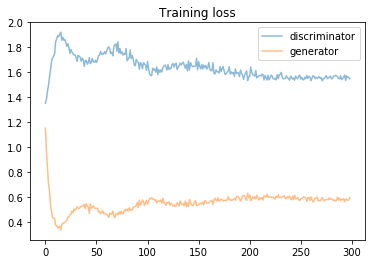

Epoch 350 Each train cost time: 3.643257007598877 Discriminator Loss: 1.5325  Generator Loss: 0.6029


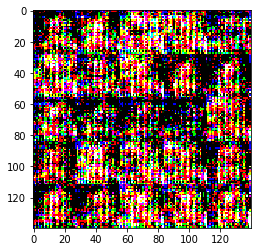

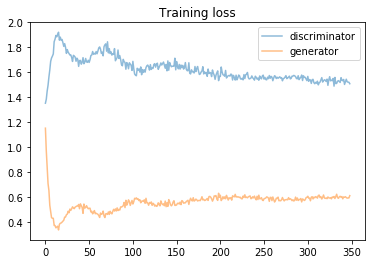

Epoch 400 Each train cost time: 3.5924566888809206 Discriminator Loss: 1.4993  Generator Loss: 0.6211


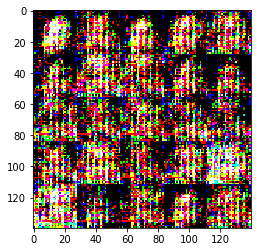

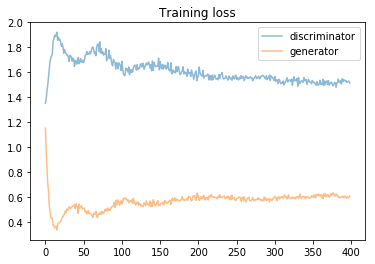

KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1
save_path = "celeba_save"


celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 
          save_folder=save_path)
""", base_i=8, load_path=save_path+"/7_gan.ckpt"""

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.